In [1]:
# 1) making all the imports relevant to the project

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import scipy
import pywt
from pywt._doc_utils import wavedec2_keys, draw_2d_wp_basis

In [3]:
# 2.1) select all images in the dataset 

DATABASE_DIR = "/home/finklerrg/IMT/F4B516/FingerprintMatching/Implementation/DB3_B/"

#### dim to transform 256x256

lins = 256
cols = 256

images_array = np.array([cv2.resize(np.array(Image.open(DATABASE_DIR+str(j)+'_'+str(i)+'.tif')), (lins,cols), interpolation = cv2.INTER_AREA) for j in range(101,111) for i in range(1,9)])
 


Number_of_images, lines, cols = images_array.shape

print('\n\n\n')
print("Database: "+ 'Biometric Systems Lab.. University of Bologna,Cesena-Italy. (www.csr.unibo.itlresearch/biolab/).')
print('\n\n\n')
print("Database with 10 people")
print("8 fingers per person")
print('\n')
print("The number of images is: " +str(Number_of_images))
print('Image resolution: '+str(cols) +'x'+ str(lines))





Database: Biometric Systems Lab.. University of Bologna,Cesena-Italy. (www.csr.unibo.itlresearch/biolab/).




Database with 10 people
8 fingers per person


The number of images is: 80
Image resolution: 256x256


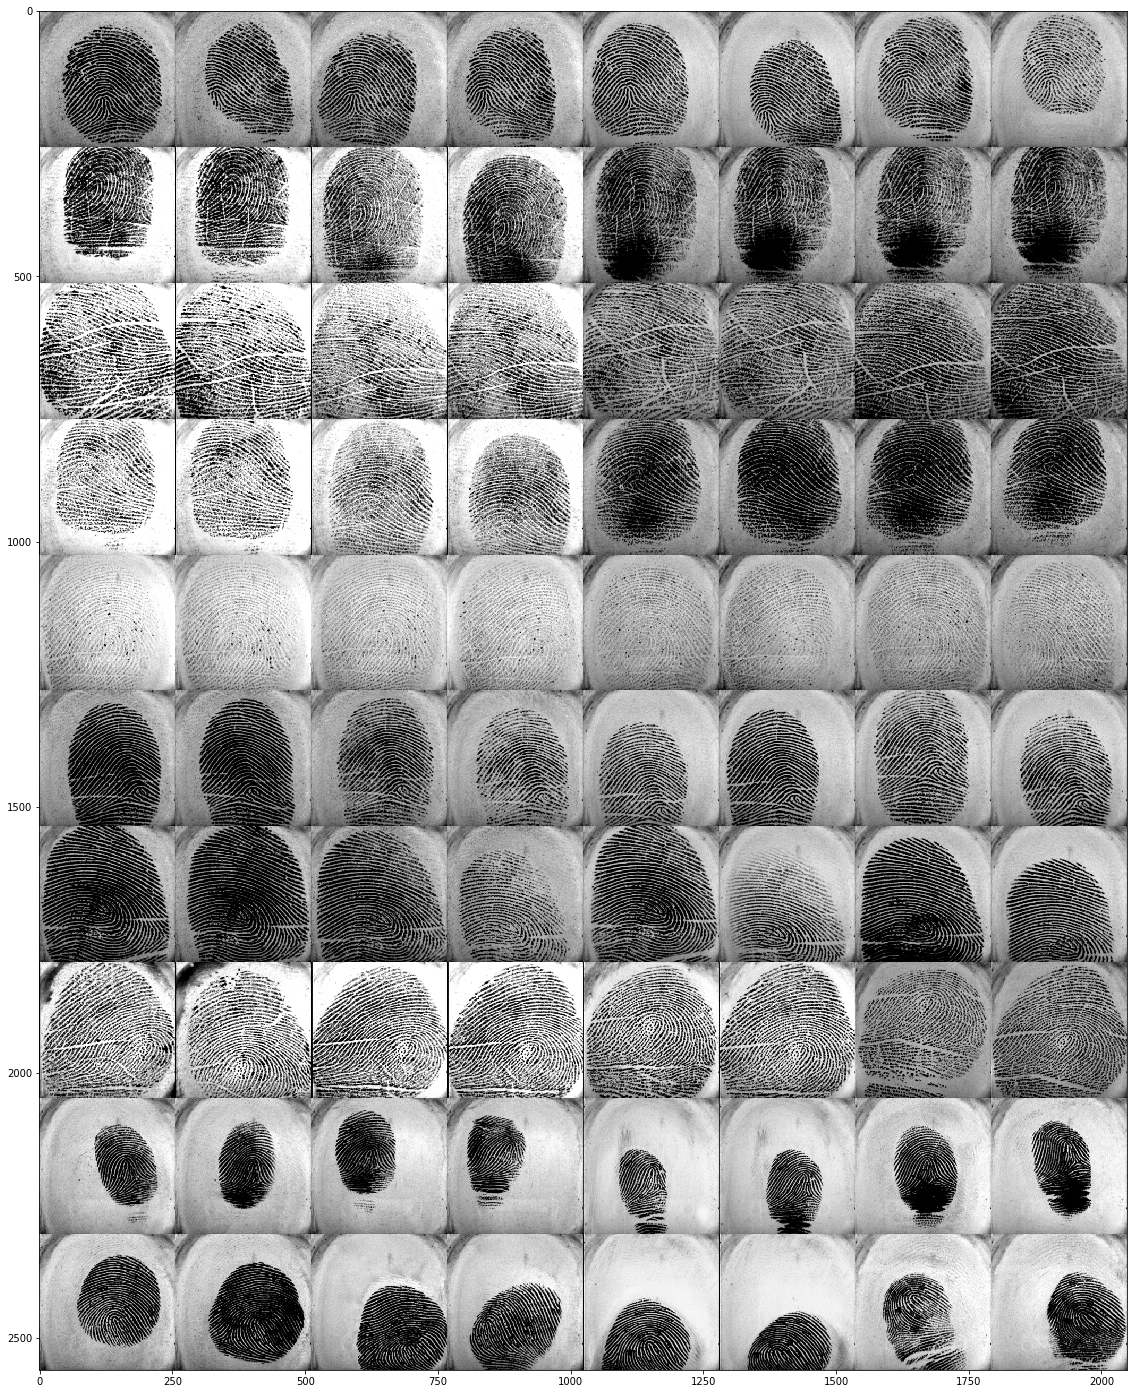

In [4]:

img_plt = images_array[0,:,:]
for i in range(1,8):
    img_plt = np.concatenate((img_plt,images_array[i,:,:]),axis=1)
imgs_plt = img_plt;


for j in range(1,10):
    img_plt = images_array[int(j*8),:,:]
    for i in range(1,8):
        img_plt = np.concatenate((img_plt,images_array[int(j*8 + i),:,:]),axis=1)
    
    imgs_plt = np.concatenate((imgs_plt,img_plt),axis=0)
    
    
plt.figure(figsize=(30,25))
plt.imshow(imgs_plt,'gray')

In [5]:
# 2.2) Find the core point, center the images with new dimension NxM

nb_imgs,lins,cols = images_array.shape
imgs_array_centered = []
centers = []
N = 64
M = 64

###### calculating images the centroid of the images
img_conj = cv2.bitwise_not(images_array)
for i in range(nb_imgs):
    Matrix = cv2.moments(img_conj[i])
    cx = int(Matrix['m10']/Matrix['m00'])
    cy = int(Matrix['m01']/Matrix['m00'])
    centers.append([cx,cy])
    imgs_array_centered.append(images_array[i,int(cy-N/2):int(cy+N/2),int(cx-M/2):int(cx+M/2)])


centers = np.array(centers)

# The array below is the centered array
imgs_array_centered = np.array(imgs_array_centered)


#fig, ax = plt.subplots()
#ax.imshow(imgs_array_centered[-1],'gray', extent=[0, 256, 0, 256])
#ax.plot(cx, cy, '.', linewidth=5, color='firebrick')


In [6]:
##### coding the centroids positions to plot below in the images
centers_plot = np.zeros(centers.shape)

for j in range(10):
    for i in range(8):
        
        #print(j*8 + i)
        centers_plot[j*8 + i,0] = centers[j*8 + i,0] + i*256
        centers_plot[j*8 + i,1] = centers[j*8 + i,1] + j*256
        #print('\n')
        #print(centers[j*8 + i])




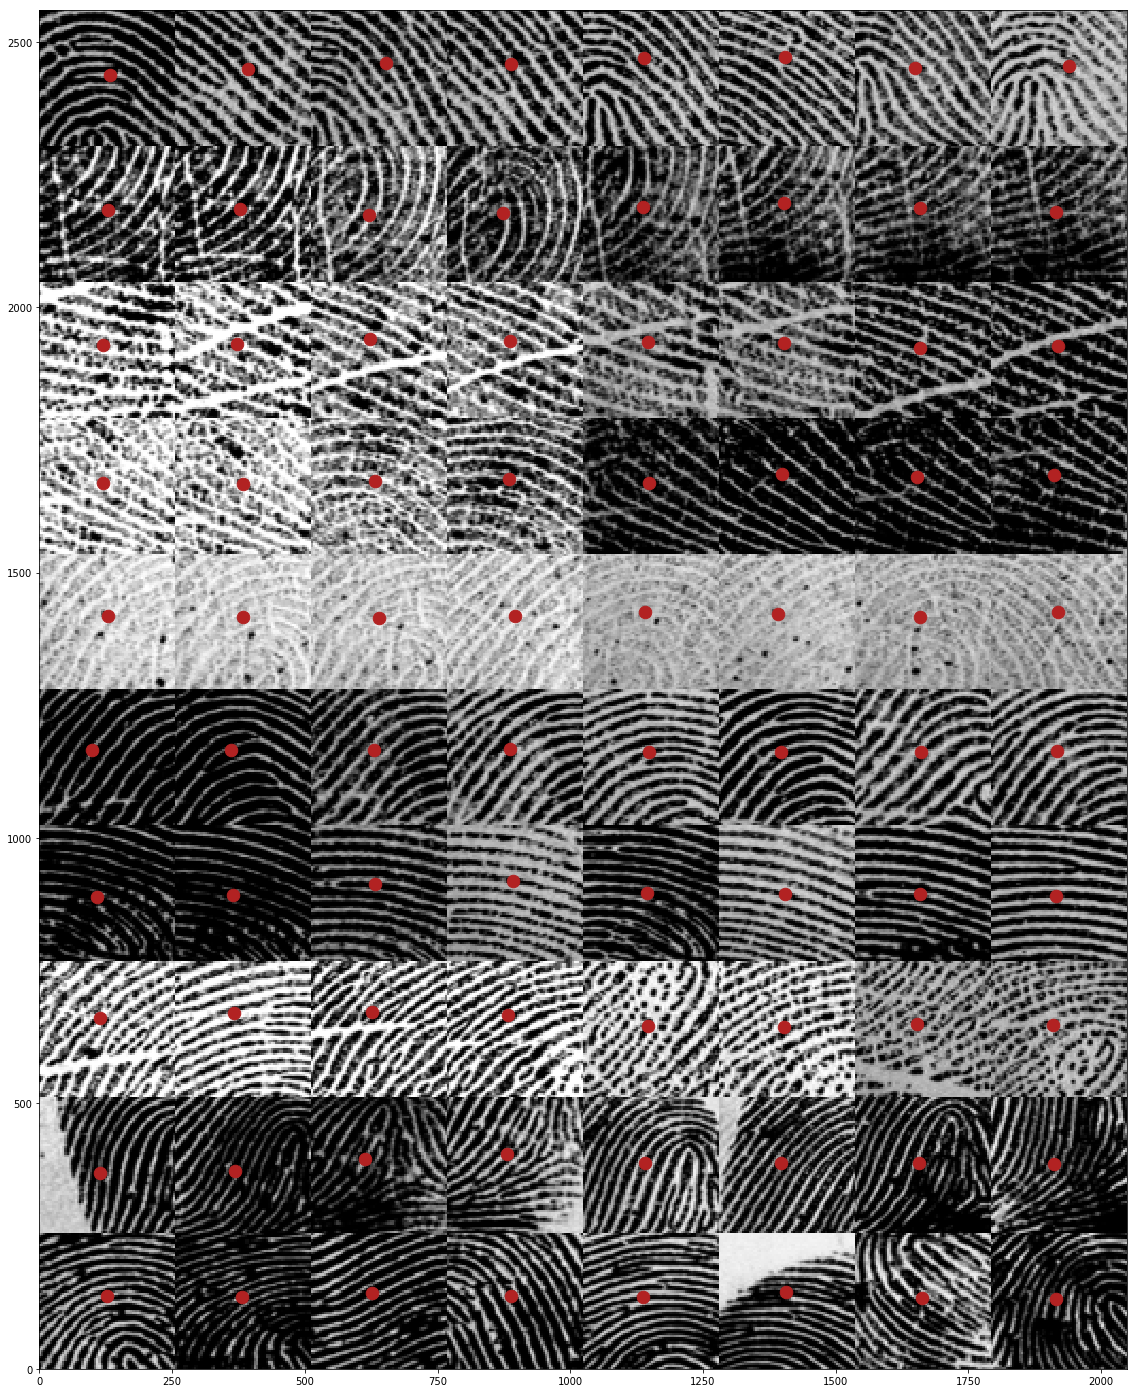

In [7]:
# Plot of the centered images

img_plt = imgs_array_centered[0,:,:]
for i in range(1,8):
    img_plt = np.concatenate((img_plt,imgs_array_centered[i,:,:]),axis=1)
imgs_plt = img_plt;


for j in range(1,10):
    img_plt = imgs_array_centered[int(j*8),:,:]
    for i in range(1,8):
        img_plt = np.concatenate((img_plt,imgs_array_centered[int(j*8 + i),:,:]),axis=1)
    
    imgs_plt = np.concatenate((imgs_plt,img_plt),axis=0)
    
    
#plt.figure(figsize=(30,25))
#plt.imshow(imgs_plt,'gray')


fig, ax = plt.subplots(figsize=(30,25))
ax.imshow(imgs_plt,'gray', extent=[0, 256*8, 0, 256*10])
ax.plot(centers_plot[:,0], centers_plot[:,1], '.', linewidth=15,markersize=25, color='firebrick')

In [8]:
# 2) Create the 4 image blocks for the central subimages
nb_images,n_lins,n_cols = imgs_array_centered.shape
images_4_parts = []

nb_lins = 32
nb_cols = 32
'''
    For each image we take the sub-images as the order below:

     __________________________
    |             |            |
    |      1      |     2      |
    |_____________|____________|                          
    |             |            |
    |      3      |     4      |
    |_____________|____________|
    




'''

for i in range(nb_images):
    images_4_parts.append(imgs_array_centered[i,:nb_lins,:nb_cols])
    images_4_parts.append(imgs_array_centered[i,nb_lins:int(2*nb_lins),:nb_cols])
    images_4_parts.append(imgs_array_centered[i,:nb_lins,nb_cols:int(2*nb_cols)])
    images_4_parts.append(imgs_array_centered[i,nb_lins:int(2*nb_lins),nb_cols:int(2*nb_cols)])

images_4_parts = np.array(images_4_parts)
images_4_parts.shape


(320, 32, 32)

In [9]:
# 3) Take the wavelet transform of each part of the image
# 4) For each J and each orientation k take the std_deviation -> if J=4 and k=3 the image is now a vector of 
#    img' = parts*J*k = 4*(4*3)
def determine_feature_vec(data,wavelet_name):

    
    ''' 
     __________________________
    |             |            |
    |      1      |     2      |
    |_____________|____________|                          
    |             |            |
    |      3      |     4      |
    |_____________|____________|

    data = [subimage_1,subimage_2,subimage_3,subimage_4]


    x' = std(x)

     _____________________________
    |       |       |      |      |
    |__cD4'_|__cD3'_|_cD2'_|_cD1'_|      
    |       |       |      |      |
    |__cV4'_|__cV3'_|_cV2'_|_cV1'_|      
    |       |       |      |      |
    |__CH4'_|__CH3'_|_CH2'_|_CH1'_|      


    feature_vector = [cH4', cV4', cD4', cH3', cV3', cD3', cH2', cV2', cD2', cH1', cV1', cD1']


    '''

    feature_vector = np.array([])
    
    for i in range(4):
        coeffs = pywt.wavedec2(data[i],level = 4, wavelet = wavelet_name)
        [cA4, (cH4, cV4, cD4),(cH3, cV3, cD3),(cH2, cV2, cD2),(cH1, cV1, cD1)] = coeffs
        feature_vector = np.concatenate((feature_vector,np.array([np.std(cH4),np.std(cV4),np.std(cD4),np.std(cH3),np.std(cV3),np.std(cD3),np.std(cH2),np.std(cV2),np.std(cD2),np.std(cH1),np.std(cV1),np.std(cD1)])))
        
        
    return feature_vector



In [10]:
vec = determine_feature_vec(images_4_parts[:4],'sym5')


/usr/local/lib/python3.5/dist-packages/pywt/_multilevel.py:45: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))


In [15]:
# 5) create the vector of 48 values of each image and save it

number_of_values = int(images_4_parts.shape[0]/4)
global_feature_vector = np.zeros((number_of_values,48))
wavelet_name = 'sym5'
for i in range(number_of_values):
    global_feature_vector[i,:] = determine_feature_vec(images_4_parts[i*4:(i+1)*4],wavelet_name)


/usr/local/lib/python3.5/dist-packages/pywt/_multilevel.py:45: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))


In [16]:
def visualize_feature_vector(feature_vector):
    feat_mat = np.reshape(feature_vector,(4,4,3))
    fig, axes = plt.subplots(1, 4, figsize=[14, 8])

    for i in range(4):
        axes[i].imshow(feat_mat[i].transpose(),'gray')
        axes[i].set_title('Subimage ' + str(i+1))

In [22]:
visualize_feature_vector(global_feature_vector[12,:])

In [23]:
# 6) separate the images in train and test


#  6.1) Create a vector of labels
X = std_values
y = np.repeat(range(1,11),8)
#print(X[70:80])
#print(y)
#print(std_values.shape) # --> (80, 48)
#print(y.shape)          # --> (80,)



#  6.2) Split the data in train and test
#from sklearn.model_selection import train_test_split  


nb_iterations = int(std_values.shape[0]/8)
X_train = np.zeros((60,48))
X_test = np.zeros((20,48))
y_train = np.zeros((60))
y_test = np.zeros((20))
for i in range(nb_iterations):
    
    shuffled_order = np.arange(8)
    np.random.shuffle(shuffled_order)
    X_train[int(i*6):int((i+1)*6),:] = X[int(i*8)+shuffled_order[0:6],:]
    X_test[int(i*2):int((i+1)*2),:] =  X[int(i*8)+shuffled_order[6:],:]
    y_train[int(i*6):int((i+1)*6)] = y[int(i*8)+shuffled_order[0:6]]
    y_test[int(i*2):int((i+1)*2)] =  y[int(i*8)+shuffled_order[6:]]


#print(X_train[59])
#print(y_train[59])
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20) 



#  Number of each one in train and test
unique, counts = np.unique(y_test, return_counts=True)
print(dict(zip(unique, counts)))

unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))





{1.0: 2, 2.0: 2, 3.0: 2, 4.0: 2, 5.0: 2, 6.0: 2, 7.0: 2, 8.0: 2, 9.0: 2, 10.0: 2}
{1.0: 6, 2.0: 6, 3.0: 6, 4.0: 6, 5.0: 6, 6.0: 6, 7.0: 6, 8.0: 6, 9.0: 6, 10.0: 6}


In [24]:
# 7) Train the classifier
#  6.3) Normalize the data

from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  
scaler.fit(X_train)

X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test)  


#  6.4) Create the model( TRAIN)

from sklearn.neighbors import KNeighborsClassifier  
classifier = KNeighborsClassifier(n_neighbors=4)  
classifier.fit(X_train, y_train)  


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=4, p=2,
           weights='uniform')

In [26]:
# 8) Test the classifier

#  6.4) Predict in test data
y_pred = classifier.predict(X_test)  
from sklearn.metrics import classification_report, confusion_matrix  
print(confusion_matrix(y_test, y_pred))  
print(classification_report(y_test, y_pred))  

[[2 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 0 1 1 0 0 0 0 0 0]
 [0 0 1 1 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 0 0 0]
 [0 0 0 1 0 1 0 0 0 0]
 [0 0 0 0 0 0 2 0 0 0]
 [0 0 0 1 0 0 0 1 0 0]
 [0 1 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 2 0 0 0]]
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00         2
         2.0       0.67      1.00      0.80         2
         3.0       0.50      0.50      0.50         2
         4.0       0.25      0.50      0.33         2
         5.0       1.00      1.00      1.00         2
         6.0       1.00      0.50      0.67         2
         7.0       0.50      1.00      0.67         2
         8.0       1.00      0.50      0.67         2
         9.0       1.00      0.50      0.67         2
        10.0       0.00      0.00      0.00         2

   micro avg       0.65      0.65      0.65        20
   macro avg       0.69      0.65      0.63        20
weighted avg       0.69      0.65      0.63        20



/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
